In [1]:
# Author: Mikita Sazanovich

%matplotlib inline
from time import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np

eps_greedy = 0.2
gamma = 0.9

field_size = 10
cows = [(4, 4), (8, 8)]
final_reward = 100

environment_random = np.random.RandomState()
algorithm_random = np.random.RandomState()

In [3]:
class StochasticAction:
    def __init__(self, outcomes, probs):
        assert len(outcomes) == len(probs)
        self.outcomes = outcomes
        self.probs = probs
        
    def execute(self):
        outcome_index = environment_random.choice(
                            len(self.outcomes), 1, p=self.probs)[0]
        return self.outcomes[outcome_index]


class State:
    def __init__(self, x, y, cow_mask):
        self.x = x
        self.y = y
        self.cow_mask = cow_mask
        self.actions = []

    def is_terminal(self):
        return self.x == 0 and self.y == 0 and (bin(self.cow_mask).count('1')
                                                == len(cows))

    def add_action(self, action):
        self.actions.append(action)

    def __eq__(self, other):
        if isinstance(other, State):
            return (self.x == other.x
                    and self.y == other.y
                    and self.cow_mask == other.cow_mask)
        else:
            return False

    def __hash__(self):
        return hash((self.x, self.y, self.cow_mask))

    def __str__(self):
        return f'({self.x} {self.y} {self.cow_mask})'

In [4]:
def build_environment(N, cows, final_reward, opposite_dir_prob=None):
    S = []
    
    def is_valid_cell(x, y):
        return 0 <= x < N and 0 <= y < N
    
    def resolve_move(state, dir_delta):
        if state.is_terminal():
            return state, 0
        x, y, mask = state.x, state.y, state.cow_mask
        new_x = x + dir_delta[0]
        new_y = y + dir_delta[1]
        if not is_valid_cell(new_x, new_y):
            return state, 0
        new_mask = mask
        if (new_x, new_y) in cows:
            cow_index = cows.index((new_x, new_y))
            new_mask |= 1 << cow_index
        new_state = S[S.index(State(new_x, new_y, new_mask))]
        reward = final_reward if new_state.is_terminal() else 0
        return new_state, reward

    dirs = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    max_mask = 1 << len(cows)
    for x in range(N):
        for y in range(N):
            for mask in range(max_mask):
                S.append(State(x, y, mask))
    for state in S:
        for dir_index in range(len(dirs)):
            outcomes = []
            probs = []
            outcomes.append(resolve_move(state, dirs[dir_index]))
            if opposite_dir_prob is None:
                probs.append(1.0)
            else:
                probs.append(1.0 - opposite_dir_prob)
                outcomes.append(resolve_move(state, dirs[dir_index ^ 1]))
                probs.append(opposite_dir_prob)
            state.add_action(StochasticAction(outcomes, probs))
    return S

In [5]:
training_iterations = 100
episode_iters_limit = 1000

seeds_to_test = 5
environment_seed = 0


def __determine_policy_reward(S, pi):
    state = S[S.index(State(0, 0, 0))]
    for _ in range(episode_iters_limit):
        if pi[state] is None:
            break
        action = pi[state]
        state, reward = action.execute()
        if reward != 0:
            return reward
    return 0


def measure_policy_performance(S, pi):
    global environment_random
    prev_environment_random = environment_random
    environment_random = np.random.RandomState(environment_seed)
    reward = __determine_policy_reward(S, pi)
    environment_random = prev_environment_random
    return reward


def evaluate_method(S, method, method_name, color_iter):
    global environment_seed, environment_random, algorithm_random
    learning_started = time()
    perf_mean = np.zeros(training_iterations, dtype=float)
    for seed in range(seeds_to_test):
        environment_seed = seed
        environment_random = np.random.RandomState(environment_seed)
        algorithm_random = np.random.RandomState(environment_seed + 1)
        perf = method(S, training_iterations)
        perf_mean += perf
    perf_mean /= seeds_to_test
    print(f'Evaluating {method_name} with {seeds_to_test} seeds took',
          time() - learning_started, 'secs')
    line, = plt.plot(perf_mean, label=method_name, c=next(color_iter))
    return line

In [6]:
def choose_action_from_stochastic_policy(pi, state):
    p = []
    for aindex in range(len(state.actions)):
        p.append(pi[(state, aindex)])
    return algorithm_random.choice(len(state.actions), 1, p=p)[0]


def find_best_action_quality(Q, state):
    best_aindex, best_q = None, None
    for aindex in range(len(state.actions)):
        cur_q = Q[(state, aindex)]
        if best_q is None or best_q < cur_q:
            best_aindex, best_q = aindex, cur_q
    return best_aindex, best_q


def update_pi_eps_greedy(pi, Q, state):
    best_aindex, best_q = find_best_action_quality(Q, state)
    best_count = 0
    for aindex in range(len(state.actions)):
        if Q[(state, aindex)] == best_q:
            best_count += 1
    for aindex in range(len(state.actions)):
        if Q[(state, aindex)] == best_q:
            pi[(state, aindex)] = ((1 - eps_greedy) / best_count +
                                   eps_greedy / len(state.actions))
        else:
            pi[(state, aindex)] = eps_greedy / len(state.actions)


def determine_policy(S, Q):
    pi = {}
    for state in S:
        best_aindex, _ = find_best_action_quality(Q, state)
        if best_aindex is None:
            pi[state] = None
        else:
            pi[state] = state.actions[best_aindex]
    return pi

In [7]:
import itertools
import heapq
    
    
class MaxPriorityQueue:
    def __init__(self):
        self.pq = []  # list of entries arranged in a heap
        self.entry_finder = {}  # mapping of tasks to entries
        self.counter = itertools.count()  # unique sequence count

    def add_task(self, task, priority):
        priority *= -1  # since heapq is a min-top heap
        if task in self.entry_finder:
            entry = self.entry_finder[task]
            if entry[0] <= priority:
                return
            self.remove_task(task)
        count = next(self.counter)
        entry = [priority, count, task]
        self.entry_finder[task] = entry
        heapq.heappush(self.pq, entry)

    def remove_task(self, task):
        entry = self.entry_finder.pop(task)
        entry[-1] = None

    def pop_task(self):
        while self.pq:
            priority, count, task = heapq.heappop(self.pq)
            if task is not None:
                del self.entry_finder[task]
                return task
        return None

In [8]:
def train_by_q_learning(S, max_iterations, alpha=0.1):
    Q = defaultdict(lambda: 0.0)
    pi = {(state, aindex): (1.0 / len(state.actions)) 
          for state in S
          for aindex in range(len(state.actions))}
    perf = []
    for _ in range(max_iterations):
        state = S[S.index(State(0, 0, 0))]
        for it in range(episode_iters_limit):
            if state.is_terminal():
                break
            aindex = choose_action_from_stochastic_policy(pi, state)
            action = state.actions[aindex]
            (to_state, reward) = action.execute()
            _, best_to_q = find_best_action_quality(Q, to_state)
            Q[(state, aindex)] += alpha * (reward + gamma * best_to_q -
                                           Q[(state, aindex)])
            update_pi_eps_greedy(pi, Q, state)
            state = to_state
        perf.append(measure_policy_performance(S, determine_policy(S, Q)))
    return perf

In [9]:
from collections import defaultdict
import math


def train_by_dyna_q(S, max_iterations, intermediate_updates=25, alpha=0.1, kappa=0.0):
    max_queue = MaxPriorityQueue()
    Q = defaultdict(lambda: 0.0)
    model = defaultdict(lambda: defaultdict(lambda: (0, 0)))
    pi = {(state, aindex): (1.0 / len(state.actions))
          for state in S
          for aindex in range(len(state.actions))}
    world_time = 0
    last_tried_action = defaultdict(lambda: 0)
    
    def compute_q_for(state, aindex):
        pair_model = model[(state, aindex)]
        items = list(pair_model.items())
        seen_times = sum(map(lambda item: item[1][1], items))
        update = -Q[(state, aindex)]
        for (to_state, (rew_acc, rew_times)) in items:
            _, best_to_q = find_best_action_quality(Q, to_state)
            update += (rew_acc / rew_times + gamma * best_to_q) * rew_times / seen_times
        update += kappa * math.sqrt(world_time -
                                    last_tried_action[(state, aindex)])
        return update

    def revise_priority_of(state, aindex):
        update = compute_q_for(state, aindex)
        D = abs(update)
        if D > 0:
            max_queue.add_task((state, aindex), D)

    leads_to = defaultdict(lambda: set())

    def learn_from_simulated_exp():
        for _ in range(intermediate_updates):
            item = max_queue.pop_task()
            if item is None:
                return
        
            (state, aindex) = item
            update = compute_q_for(state, aindex)
            Q[(state, aindex)] += alpha * update
            update_pi_eps_greedy(pi, Q, state)

            for (from_state, aindex) in leads_to[state]:
                revise_priority_of(from_state, aindex)

    perf = []
    for _ in range(max_iterations):
        state = S[S.index(State(0, 0, 0))]
        for _ in range(episode_iters_limit):
            if state.is_terminal():
                break
            world_time += 1
            aindex = choose_action_from_stochastic_policy(pi, state)
            last_tried_action[(state, aindex)] = world_time

            action = state.actions[aindex]
            (to_state, reward) = action.execute()
            pair_model = model[(state, aindex)]
            observed = pair_model[to_state]
            pair_model[to_state] = (observed[0] + reward, observed[1] + 1)
            leads_to[to_state].add((state, aindex))

            revise_priority_of(state, aindex)
            state = to_state

            learn_from_simulated_exp()
        perf.append(measure_policy_performance(S, determine_policy(S, Q)))
    return perf

States: 400
Evaluating Dyna-Q with 5 seeds took 108.44383597373962 secs
Evaluating Dyna-Q+ with 5 seeds took 76.55742979049683 secs
Evaluating Q-learning with 5 seeds took 32.01388430595398 secs


Text(0,0.5,'Performance mean')

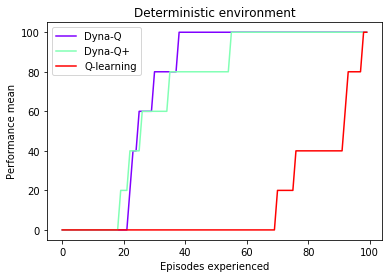

In [13]:
S = build_environment(field_size, cows, final_reward)
print('States:', len(S))

color = iter(cm.rainbow(np.linspace(0, 1, 3)))

handles = []
handles.append(
    evaluate_method(
        S, 
        lambda  S, iter ations: train_by_dyna_q(S, iterations, kappa=0.0),
        'Dyna-Q',
        color))
handles.append(
    evaluate_method(
        S,
        lambda S, iterations: train_by_dyna_q(S, iterations, kappa=1e-3),
        'Dyna-Q+',
        color))
handles.append(
    evaluate_method(
        S,
        train_by_q_learning,
        'Q-learning',
        color))
plt.legend(handles=handles)
plt.title('Deterministic environment')
plt.xlabel('Episodes experienced')
plt.ylabel('Performance mean')

We can clearly see the benefits of reward propogation (implemented via 'prioritized sweeping'). While Q-learning only updates participating pairs, Dyna-Q updates up to 25 pairs before ones that got the reward.

Dyna-Q and Dyna-Q+ do not differ a lot, because we have a non-changing deterministic environemt.

States: 400
Evaluating Dyna-Q with 5 seeds took 210.19593405723572 secs
Evaluating Dyna-Q+ with 5 seeds took 204.57871103286743 secs
Evaluating Q-learning with 5 seeds took 22.771246910095215 secs


Text(0,0.5,'Performance mean')

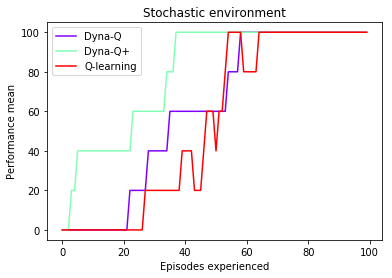

In [12]:
S = build_environment(field_size, cows, final_reward, opposite_dir_prob=0.3)
print('States:', len(S))

color = iter(cm.rainbow(np.linspace(0, 1, 3)))

handles = []
handles.append(
    evaluate_method(
        S,
        lambda S, iterations: train_by_dyna_q(S, iterations, kappa=0.0),
        'Dyna-Q',
        color))
handles.append(
    evaluate_method(
        S,
        lambda S, iterations: train_by_dyna_q(S, iterations, kappa=1e-3),
        'Dyna-Q+',
        color))
handles.append(
    evaluate_method(
        S,
        train_by_q_learning,
        'Q-learning',
        color))
plt.legend(handles=handles)
plt.title('Stochastic environment')
plt.xlabel('Episodes experienced')
plt.ylabel('Performance mean')

In the stochastic environment we see that just propogating the rewards do not work that well. But encouraging exploration of old action pairs works perfect. That is what Dyna-Q+ does.
